<a href="https://colab.research.google.com/github/tsakailab/alpp/blob/main/colab/alpp_model_cam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# class activation mapping (CAM)<br>クラス活性化マッピング

What specific local features of an image does a CNN model use to compute its output?
- Observe the [**class activation map (CAM)**](http://cnnlocalization.csail.mit.edu/Zhou_Learning_Deep_Features_CVPR_2016_paper.pdf).
- Observe [**Grad-CAM**](https://arxiv.org/pdf/1610.02391.pdf), which is calculated by back propagation.


CNNは，画像のどこの局所特徴に基づき出力を算出しているのでしょうか．
- モデルが作る[**クラス活性化マップ（class activation map; CAM)**](http://cnnlocalization.csail.mit.edu/Zhou_Learning_Deep_Features_CVPR_2016_paper.pdf)を観察します．
- 逆伝播で算出する[**Grad-CAM**](https://arxiv.org/pdf/1610.02391.pdf)を観察します．

In [1]:
#@title Defines a function to display an image/feature map of a 4D array.<br>4D arrayの画像・特徴マップを表示する関数を定義します．
import numpy as np

#!pip install -q --upgrade matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm as tsn


def plotImages(img_arr, lbl_arr, colors_arr=None, figsize=(8, 4), mag=2, mean=0., std =1.):

    if len(img_arr) <= min(figsize): rc = (1, len(img_arr))
    else: rc = (figsize[1], min(len(img_arr)//figsize[1], figsize[0]))
    fig, axes = plt.subplots(rc[0], rc[1], figsize=(rc[1]*mag, rc[0]*mag))
    if len(img_arr) != 1:
        axes = axes.flatten()
    else:
        axes = [axes]
    if colors_arr is None: colors_arr = ['k']*len(lbl_arr)
    for img, lbl, c, ax in zip( img_arr, lbl_arr, colors_arr, axes):
        img = img.numpy().transpose((1,2,0))
        img = std * img + mean
        img = np.clip(img, 0, 1)
        ax.imshow(img)
        ax.set_title(lbl, color=c)
        ax.axis('off')
    plt.tight_layout()
    plt.show()


# plot feature maps
def plotFeaturemaps(maps, max_ch=12, top=None, figsize=(8, 3), mag=1):

    if maps.ndim == 1:
        plt.figure(figsize=figsize)
        plt.bar(np.arange(maps.shape[0]), maps, width=1.0)
        plt.tight_layout()
        plt.show()
        return

    if maps.ndim != 3: return
    # maps.shape = (ch, h, w)
    if top is not None:
        nmaps = min(top, maps.shape[0])
        nrows, ncols = 1, nmaps
        channels = np.argsort(-np.sum(np.abs(maps.reshape((maps.shape[0],-1))**2), axis=1))[:nmaps]
    else:
        nmaps = min(maps.shape[0], max_ch*max_ch)
        ncols = int(np.ceil(np.sqrt(nmaps)))
        nrows = int(np.floor(nmaps / ncols))
        nmaps = nrows * ncols
        channels = range(nmaps)

    norm = tsn(vmin=np.minimum(maps[:].min(),-1e-6), vcenter=0, vmax=np.maximum(maps[:].max(),1e-6)) # maps[channels]
    fig = plt.figure(figsize=(ncols*mag, nrows*mag))
    for ch in range(nmaps):
        ax1 = fig.add_subplot(nrows, ncols, ch+1)
        ax1.imshow(maps[channels[ch]], cmap='bwr_r', norm=norm)#, aspect='equal')
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])
    plt.tight_layout()
    plt.show()

from matplotlib import cm as cmap
import warnings
# x[H,W]
def toColorImg(x, cm='bwr_r', norm=None):
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore', category=DeprecationWarning, message="__array_wrap")
        if norm is None:
            norm = tsn(vmin=np.minimum(x[:].min(),-1e-6), vcenter=0, vmax=np.maximum(x[:].max(),1e-6)) # maps[channels]
    sm = cmap.ScalarMappable(norm=norm, cmap=cm)
    return sm.to_rgba(x)[:,:,:3]

## Loads a trained CNN model.<br>学習済みのCNNモデルを読み込みます．

- The CNN model is assumed to be saved by `torch.save()` in Google Drive.
- Set `model_path` and `model_name` to the location and file name of the CNN model.
- The CNN model is assumed to be an entity of class name `my_model`.
    - `my_model` is assumed to consist of `features`, `avgpool`, and `classifier` created by `nn.Sequential`.
    - To compute the class activation map, the `classifier` is assumed to have only one full-connected layer by `nn.Linear`.
    - The `features` is assumed to create a feature map from the color image input, and the feature map is passed through `avgpool` to the `classifier`.
    - We assume that `avgpool` is defined as [global average pooling (GAP)](https://paperswithcode.com/method/global-average-pooling).



- CNNモデルは，torch.saveでGoogleドライブに保存されているものとします．
- CNNモデルの場所とファイル名を `model_path` と `model_name` に設定してください．
- CNNモデルは，クラス名`my_model`の実体であるとします．
    - `my_model`は，`nn.Sequential`で作られた `features`, `avgpool`, `classifier`から構成されるものとします．
    - CAMを計算するため，`classifier` は全結合層`nn.Linear`をひとつだけをもつものとします．
    - `features` はカラー画像の入力から特徴マップを作り，その特徴マップは `avgpool` を経て `classifier` へ渡されるものとします．
    - `avgpool`は[全体平均プーリング（global average pooling; GAP）](https://paperswithcode.com/method/global-average-pooling)として定義されているものと仮定します．

In [2]:
from google.colab import drive
drive.mount('/content/drive')
model_path="/content/drive/MyDrive/"

#model_path=""
model_name = "model.pkl"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import torch

# model definition
class my_model(torch.nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.features = torch.nn.Sequential()
        self.avgpool = torch.nn.Sequential()
        self.classifier = torch.nn.Sequential()

    def forward(self, x):
        features_out = self.features(x)
        gap = self.avgpool(features_out).squeeze(-1).squeeze(-1) # [B, C, H=1, W=1] -> [B, C]
        classifier_out = self.classifier(gap)

        return classifier_out

'''
    def get_features(self, x):
        features_out = self.features(x)
        return features_out
'''

#weight_only = True
#torch.serialization.add_safe_globals([my_model, torch.nn.Sequential, torch.nn.Linear, torch.nn.Conv2d, torch.nn.BatchNorm2d, torch.nn.ReLU, torch.nn.MaxPool2d, torch.nn.AdaptiveAvgPool2d])
weights_only = False

# load
torch.nn.Module.dump_patches = True
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = torch.load(model_path + model_name, map_location=device, weights_only=weights_only)
model.eval()
print(model)

model_linear = model.classifier[0]

my_model(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


In [4]:
categories = ['ants', 'bees']
hparam = {'image_size': (224, 224),
          'mean_color': [0.485, 0.456, 0.406], 'std_color': [0.229, 0.224, 0.225]}

# ants
#uri = "https://i.natgeofe.com/n/ab3c5297-7321-4846-9f54-3c4114165f2d/ants_thumb_3x4.jpg"
#uri = "https://thisismygarden.com/wp-content/uploads/2020/07/controlling-ants-on-plants-1.jpg"
#uri = "https://static01.nyt.com/images/2018/08/19/science/21SCI-TAKE/21SCI-TAKE-videoSixteenByNine3000.jpg"
#uri = "https://images.theconversation.com/files/280292/original/file-20190619-171183-p0runh.jpg"
#uri = "https://images.theconversation.com/files/280045/original/file-20190618-118543-13mbljf.jpg"
#uri = "https://api.time.com/wp-content/uploads/2015/07/ants-carrying-leaves.jpg"
#uri = "https://www.terro.com/media/Articles/TERRO/Get-Rid-of-Sugar-Ants-in-3-Steps.jpg"

# bees
uri = "https://images2.minutemediacdn.com/image/upload/c_crop,h_1238,w_2200,x_0,y_163/f_auto,q_auto,w_1100/v1621529138/shape/mentalfloss/53691-gettyimages-165987177.jpg"
#uri = "https://grist.org/wp-content/uploads/2015/04/bee-e1452114220653.jpg"
#uri = "https://static01.nyt.com/images/2018/06/19/science/08BEES/08BEES-facebookJumbo.jpg"
#uri = "https://media-cldnry.s-nbcnews.com/image/upload/t_fit-2000w,f_auto,q_auto:best/newscms/2017_12/1941536/170322-honey-bee-mn-1700.jpg"

# ants and bees
#uri = "https://github.com/tsakailab/alpp/raw/2a23fe03fc080fd439db8889a184851c7e37b585/data/28-1453966107-ants-honey-bee.jpg"

(height, width, channels) = (619, 1100, 3)


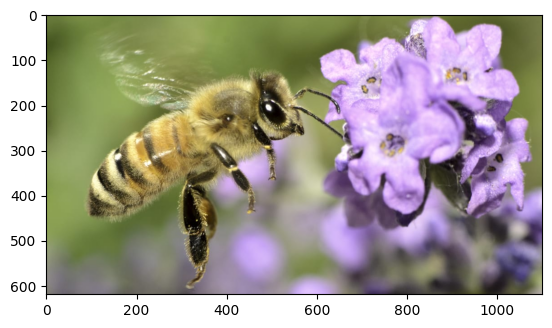

In [5]:
#@title Downloads an image for model input.<br>入力用に画像をダウンロードして表示します．
import imageio
cimg = imageio.v3.imread(uri)

# resize
from PIL import Image
pimg = Image.fromarray(cimg)

import numpy as np
#cimg = np.array(pimg.resize((cimg.shape[1] * 128 // cimg.shape[0], 128)))
cimg = np.array(pimg)

print("(height, width, channels) =", cimg.shape)
import matplotlib.pyplot as plt
plt.imshow(cimg)
plt.show()

In [6]:
#@title Obtains the model output and feature maps.<br>モデルの出力と特徴マップを得ます．
from torchvision import transforms
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(hparam['image_size']),
    transforms.ToTensor(),
    transforms.Normalize(mean=hparam['mean_color'], std=hparam['std_color']),
])

in_img = preprocess(pimg)

model.eval()
with torch.no_grad():
    output = model(in_img.unsqueeze(0).to(device))

# The output has unnormalized scores. To get probabilities, you can run a softmax on it.
probabilities = torch.nn.functional.softmax(output[0], dim=0)

# Show the classification result
top_prob, top_catid = torch.topk(probabilities, len(categories))
print("Classified as \033[1m", categories[top_catid[0]], "\033[0m, model output =", output)
for i in range(top_prob.size(0)):
    print(categories[top_catid[i]], "(", top_catid[i].cpu().numpy(), ")", "{:.2f} %".format(top_prob[i].item()*100))

Classified as  bees , model output = tensor([[-1.8812,  0.9934]])
bees ( 1 ) 94.66 %
ants ( 0 ) 5.34 %


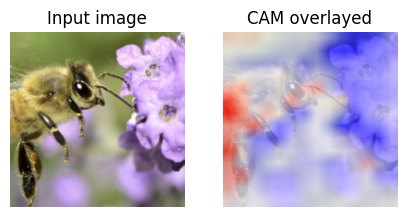

ants avg=-1.93,  bees avg=1.05,  

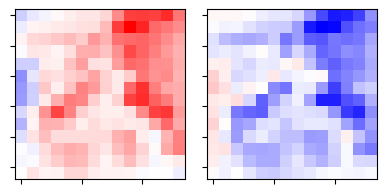

In [7]:
#@title Displays CAM.<br>CAMを作成して表示します．

def get_features(self, x):
    features_out = self.features(x)
    return features_out

# append get_features() to the model instance as a class method
import types
model.get_features = types.MethodType(get_features, model)

# CAM as a 1x1 filter
class_activation_mapper = torch.nn.Conv2d(model_linear.weight.shape[1], model_linear.weight.shape[0], 1, padding=0, bias=False)
class_activation_mapper.weight = torch.nn.Parameter(model_linear.weight.unsqueeze(-1).unsqueeze(-1))

# create CAM from the feature maps
with torch.no_grad():
    features_out = model.get_features(in_img.unsqueeze(0).to(device))
    cam = class_activation_mapper(features_out).squeeze()
    cam_avgs = cam.mean([-2,-1]).cpu().numpy().tolist()

ccam = toColorImg(cam[top_catid[0]].cpu(), cm='bwr_r')#.transpose(2,0,1)
# resize cam
ccam_normalizer = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=hparam['mean_color'], std=hparam['std_color']),
        transforms.Resize(hparam['image_size'])#, interpolation=0),
    ])
ccam = ccam_normalizer(ccam)

# overlay cam on input
alpha = 0.25
cam_image = in_img*alpha + ccam*(1-alpha)

# display input and CAM images
plotImages([in_img, cam_image], ["Input image", "CAM overlayed"], mag=2.2, mean=hparam['mean_color'], std=hparam['std_color'])
for cat, acm in zip(categories, cam_avgs): print(cat, "avg={:.2f},  ".format(acm), end='')
plotFeaturemaps(cam.detach().cpu().numpy(), mag=2)

## Next, observe the Grad-CAM.<br>Grad-CAMを観察しましょう．

Installs [M3d-Cam](https://github.com/MECLabTUDA/M3d-Cam).

[M3d-Cam](https://github.com/MECLabTUDA/M3d-Cam)をインストールします．


In [8]:
!pip install -q medcam

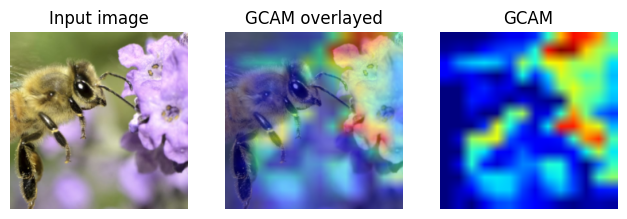

In [9]:
#@title Displays the Grad-CAM.<br>Grad-CAMを作成して表示します．
from medcam import medcam

# set requires_grad=True for all model parameters so that the gradients are available in Grad-CAM.
for param in model.parameters():
    param.requires_grad = True

# https://meclabtuda.github.io/M3d-Cam/medcam/medcam_inject.html#medcam.medcam_inject.inject
model_gcam = medcam.inject(model, backend='gcam', label='best').to(device)# label=0
_ = model_gcam(in_img.unsqueeze(0).to(device))
gcam = model_gcam.get_attention_map()

#cgcam = toColorImg(gcam[0][0],cm='bwr_r')#.transpose(2,0,1)
from matplotlib.colors import Normalize as norm
cgcam = toColorImg(gcam[0][0],cm='jet', norm=norm(vmin=gcam[:].min(), vmax=gcam[:].max()))

# resize cam
ccam_normalizer = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=hparam['mean_color'], std=hparam['std_color']),
        transforms.Resize(hparam['image_size'])#, interpolation=0),
    ])
cgcam = ccam_normalizer(cgcam)

# overlay cam on input
alpha = 0.5
gcam_image = in_img*alpha + cgcam*(1-alpha)

# display input and CAM images
import matplotlib.cm as cm
plotImages([in_img, gcam_image, cgcam], ["Input image", "GCAM overlayed", "GCAM"], mag=2.2, mean=hparam['mean_color'], std=hparam['std_color'])

#model_gcam = medcam.inject(model, save_maps=True, output_dir='attention_maps', backend='gcam', label='best')# label=0
#_ = model_gcam(in_img.unsqueeze(0).to(device))
#from IPython.display import Image
#Image('/content/attention_maps/features/attention_map_0_0_0.png')